# Women in STEM workforce: predict income

### What is in this notebook?

We have looked at the gender pay gap over the years in the STEM workforce in the EDA notebook. The analysis also shows how the gender gap compare to one another in the various fields in STEM areas. In this notebook, I take a look at the machine learning models to predict the income and prime job activity with given other aspects of the data. It would answer the question of what kind of pay and what types of job would a STEMer expect to have in the work force.

# Importing and Tidying the Data

In [2]:
# import important stuff
import numpy as np
import pandas as pd

In [3]:
# import visulization modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
%matplotlib inline

In [4]:
# import stats modules
from scipy.stats import ttest_ind, chi2_contingency

In [5]:
# import machine learning modules
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [6]:
# import the data from csv file with a series of NAN values 
df1 = pd.read_csv('./../data/highered_00004.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
df1 = df1.drop(['REFID'], axis=1)
df2 = pd.read_csv('./../data/highered_00007.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
df3 = pd.read_csv('./../data/highered_00008.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
dfm = df1.merge(df2,  on=['PERSONID', 'YEAR', 'WEIGHT', 'SAMPLE', 'SURID'])

In [7]:
# explanation of the survey https://highered.ipums.org/highered/survey_designs.shtml

# Respondents from each of these three surveys with science or engineering degrees                               ##
# or occupations are compiled into one dataset: the SESTAT (the Scientists and Engineers Statistical Data System)##
df = dfm.merge(df3, on=['PERSONID', 'YEAR', 'SURID'])


In [8]:
#drop columns with irrelevant or many missing data
df_employed = df[df['LFSTAT']==1]
df_employed_small = df_employed.drop(['CTZUS', 'WEIGHT', 'WRKG', 'NRREA','FNVS', 'CHTOT', 'CPI2009C', 'PERSONID', 'LFSTAT','BA03Y5', 'LOOKWK'], axis=1)
df_employed_l = df_employed_small.dropna()

## Correlations Overviews


In [9]:
df_employed_l.corr()['SALARY']

YEAR        0.047753
SAMPLE      0.049694
SURID       0.193761
AGE         0.186057
BIRYR      -0.162161
GENDER      0.257586
MINRTY     -0.102562
RACETH     -0.101382
BTHUS      -0.055799
CTZUSIN     0.012500
NBAMED     -0.037537
NBAMEMG    -0.034085
DGRDG       0.263496
HD03Y5     -0.167808
NDGMED     -0.010046
NDGMEMG    -0.001453
HRSWKGR     0.403946
WKSWKGR     0.176768
OCEDRLP    -0.128177
NOCPR      -0.091245
NOCPRMG    -0.056801
SALARY      1.000000
JOBSATIS   -0.140447
EMSEC       0.215927
EMSIZE      0.169909
GOVSUP      0.022820
WAPRSM     -0.034008
ACTCAP      0.042460
ACTDED      0.126313
ACTMGT      0.119822
ACTRD       0.115217
ACTRDT     -0.012041
ACTRES      0.036424
ACTTCH     -0.183005
WKTRNI      0.007476
WAPRI      -0.172204
WASEC      -0.133979
WASCSM     -0.141206
Name: SALARY, dtype: float64

In [10]:
#Change salary from a numeric column to a catagorical column. It is more practical to predict 
# either a high salary or a low salary will be expected, compared with the exact number. 

# This project also looks into the prediction of numeric salary using several models. Due to privacy reasons, this 
# set of data do not provide locations of individuals. It limits the accuracy of the models since the geolocation of 
# a entry could make a huge difference in the cost of living and income numbers. Please find details of the regression
# models in another notebook in the same folder.

def salary_bracket(ls):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s<60000:
            new_s[i] = 0
        else:
            new_s[i] = 1
    return new_s

# define a dataframe only contains salary that is larger than 0 (eliminate the entry fault)
df_employed_clf =[]
df_employed_clf = df_employed_l[(df_employed_l['SALARY']>0)]



new_salary = salary_bracket(df_employed_clf['SALARY'])

In [11]:
df_employed_nod = []
df_employed_nod = df_employed_clf.assign(salary_d=pd.Series(new_salary).values)
df_employed_nod.salary_d = df_employed_nod.salary_d.astype('category')
df_employed_nod=df_employed_nod.drop(['SALARY'], axis=1)
df_employed_nod=df_employed_nod[(df_employed_nod['WKSWKGR']==3) | (df_employed_nod['WKSWKGR']==4)]

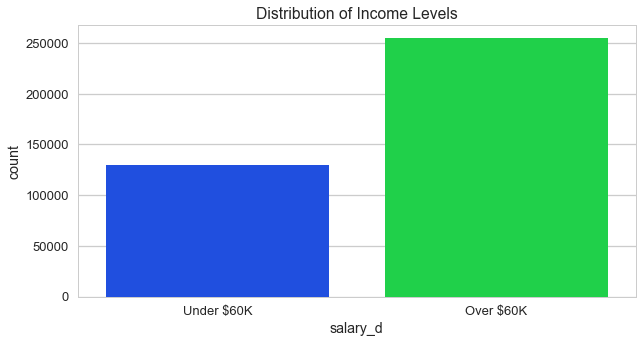

Percent of low income: 33.80%


In [12]:
plt.figure(figsize=(10,5))
g = sns.countplot(x='salary_d', data=df_employed_nod, palette='bright')
g.set_xticklabels(['Under $60K', 'Over $60K'])
plt.title('Distribution of Income Levels')
plt.show()

print('Percent of low income: {:.2f}%'.format(len(df_employed_nod[df_employed_nod.salary_d==0])/len(df_employed_nod)*100))

<function matplotlib.pyplot.tight_layout>

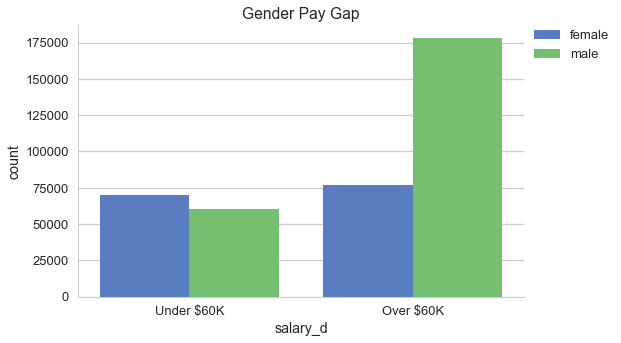

In [13]:
#bar plot of gender and salary 
fig=plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)
sns.countplot(data=df_employed_nod, x = 'salary_d', hue= 'GENDER', palette="muted", ax=ax)
sns.despine()
plt.title('Gender Pay Gap')
ax.set_xticklabels(['Under $60K', 'Over $60K'])
lgd=ax.legend(['female', 'male'], bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.tight_layout
#plt.savefig('./../results/gendersalary.png',bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 150)


It is obvious from the plot above that there are much more men making more than $60k a year compared than women. We have learned from the EDA notebook that the gender pay gap exists and did not improve over the years from 2003 to 2013. This is a look at it from another perspective. 

In [14]:
# It is worth noting that the numerical data: birth year, year and age are dependent variables. Here we choose to drop birth year.
# Some of the categorical data is dependent variables, they are xxxxxMG which indicates the major group of the finer defined groups. 
# we drop them as well. 
df_employed_nod = []
df_employed_nod = df_employed_clf.assign(salary_d=pd.Series(new_salary).values)
df_employed_nod.salary_d = df_employed_nod.salary_d.astype('category')
df_employed_nod=df_employed_nod.drop(['SALARY'], axis=1)
df_employed_nod = df_employed_nod.drop(['BIRYR', 'NBAMEMG', 'NOCPRMG'], axis=1)
df_employed_nod=df_employed_nod[(df_employed_nod['HRSWKGR']==3) | (df_employed_nod['HRSWKGR']==4)]

In [15]:
numeric = ['YEAR', 'AGE']
feature_df = df_employed_nod.drop(['salary_d'],axis=1)
categoric = feature_df.columns.difference(numeric)

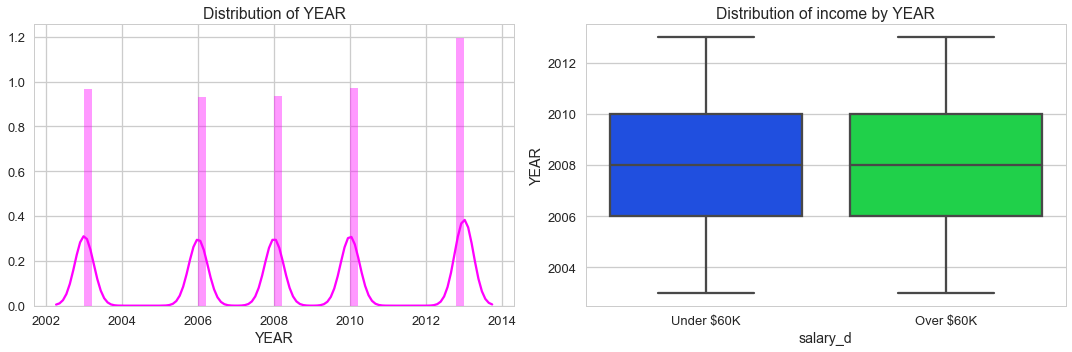

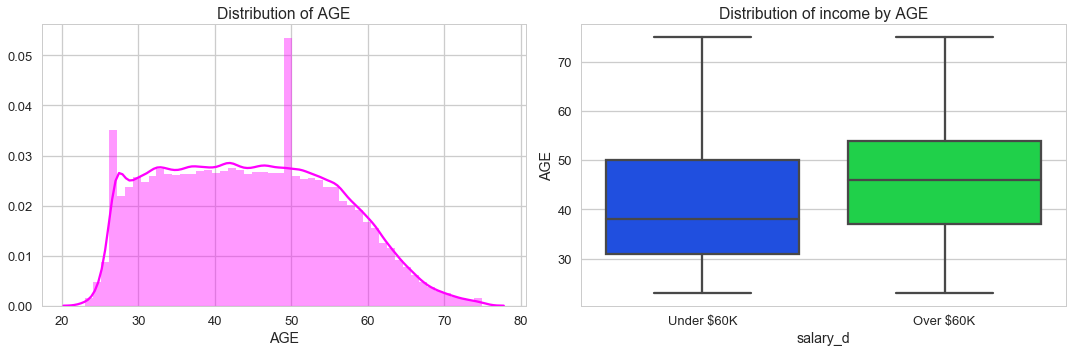

P-values from t-tests


,Attribute,P_value
1,AGE,0.000000e+00
0,YEAR,9.883499e-98


In [16]:
p_vals = pd.DataFrame(columns=['Attribute', 'P_value'])

for col in numeric:
   
    # Plotting distributions of each column
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    sns.distplot(df_employed_nod[col], color='magenta')
    plt.title('Distribution of {}'.format(col))

    # Plotting distributions of each column by income level
    plt.subplot(122)
    g = sns.boxplot(x='salary_d', y=col, data=df_employed_nod, palette='bright')
    g.set_xticklabels(['Under $60K', 'Over $60K'])
    plt.title('Distribution of income by {}'.format(col))
    plt.tight_layout()
    plt.show()

    # Calculating pvalues from t-test
    t_val, p_val = ttest_ind(df_employed_nod[df_employed_nod['salary_d']==0][col],
                                df_employed_nod[df_employed_nod['salary_d']==1][col])
    p_vals = p_vals.append({'Attribute':col, 'P_value':float(p_val)}, ignore_index=True)
    

# Printing p-values of t-tests, sorted by p-values
print('P-values from t-tests')
p_vals.sort_values('P_value')


The p_value for both numeric columns are small, which means age and year are both statistically significant to determine the salary level of an individual. We will keep they both. 


In [17]:
feature_df = df_employed_nod.drop(['salary_d'],axis=1)
categoric = feature_df.columns.difference(numeric)
df_employed_nod_sig = pd.get_dummies(data=df_employed_nod, columns=categoric, drop_first=True)
df_employed_nod_sig.head()

,YEAR,AGE,salary_d,ACTCAP_1.0,ACTDED_1.0,ACTMGT_1.0,ACTRD_1.0,ACTRDT_1.0,ACTRES_1.0,ACTTCH_1.0,...,WASEC_10.0,WASEC_11.0,WASEC_12.0,WASEC_13.0,WASEC_14.0,WASEC_15.0,WKSWKGR_2.0,WKSWKGR_3.0,WKSWKGR_4.0,WKTRNI_1.0
0,2003,47,0.0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,1
1,2003,66,1.0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2003,60,1.0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,2003,30,1.0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,1,1
5,2003,51,1.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1


In [18]:
p_vals_cate = pd.DataFrame(columns=['Attribute', 'P_value'])
categoric = df_employed_nod_sig.columns.difference(['YEAR','AGE','salary_d'])
p_large = []

for col in categoric:
    # Creating cross tabulated data for Chi-square test
    counttable = pd.crosstab(df_employed_nod_sig[col], df_employed_nod_sig['salary_d'])
    chi2, p, dof, ex = chi2_contingency(counttable, correction=False)
    p_vals_cate = p_vals_cate.append({'Attribute':col, 'P_value':float(p)}, ignore_index=True)
    if p>0.01:
         p_large.append(col)
    
# Printing p-values of Chi-squared tests, sorted by p-values
print('P-values from Chi-Squared Contingency Tests')
p_vals_cate.sort_values('P_value')

P-values from Chi-Squared Contingency Tests


,Attribute,P_value
0,ACTCAP_1.0,0.000000e+00
105,NOCPR_621995.0,0.000000e+00
102,NOCPR_560940.0,0.000000e+00
101,NOCPR_540890.0,0.000000e+00
98,NOCPR_505005.0,0.000000e+00
86,NOCPR_192895.0,0.000000e+00
83,NDGMEMG_5,0.000000e+00
164,WKSWKGR_4.0,0.000000e+00
80,NDGMEMG_2,0.000000e+00
79,NDGMED_799995,0.000000e+00


In [19]:
df_employed_nod_sig_2  = df_employed_nod_sig.drop(p_large, axis=1)
df_employed_nod_sig_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333044 entries, 0 to 478746
Columns: 155 entries, YEAR to WKTRNI_1.0
dtypes: category(1), int64(2), uint8(152)
memory usage: 66.2 MB


In [20]:
df_employed_nod_sig_3 = df_employed_nod_sig_2#.sample(frac=0.1, random_state=42)
# Identify variables
X = df_employed_nod_sig_3.drop('salary_d', axis=1)
y = df_employed_nod_sig_3.salary_d

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=41)


rus = RandomUnderSampler(random_state=41)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)

print('Raw Training Set Percent Under $60,000: {:.1f}%'.format(
    len(y_train[y_train == 0])/len(y_train)*100))
print('Resampled Training Set Percent Under $60,000: {}%'.format(
    len(y_rus[y_rus == 0])/len(y_rus)*100))

/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Raw Training Set Percent Under $60,000: 28.7%
Resampled Training Set Percent Under $60,000: 50.0%


### Logistic regression:

Logistic regression parameter optimization:

In [21]:
clf = LogisticRegression()
parameters = [{'C':[0.1,1,10,100], 'solver':['lbfgs'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100], 'solver':['liblinear'], 'penalty':['l1', 'l2'], 'fit_intercept':[True]}]
# Instantiating and fitting model through grid search
grid_logR = GridSearchCV(clf, param_grid=parameters)
grid_logR.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_logR.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_logR.best_params_
print('Best Parameters:', best_params)

Best Score: 0.778517872711
Best Parameters: {'C': 100, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}


In [22]:
#initiate a instance for classifier
clf = LogisticRegression(**best_params)
#clf = RandomForestClassifier(n_estimators=50, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

scores_LR_train = cross_val_score(clf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_LR_train.mean(), 
                                                                                 scores_LR_train.std()*2))
scores_LR_test = cross_val_score(clf, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_LR_test.mean(), 
                                                                                 scores_LR_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.77922(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 0.81202(+/- 0.00)
Confusion matrix on the test data:
[[ 51360  14203]
 [ 37744 129824]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.58      0.78      0.66     65563
        1.0       0.90      0.77      0.83    167568

avg / total       0.81      0.78      0.79    233131



In [23]:
# Creating Data Frame with Features and Logistic Regression Coefficients
coefs_lg = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(clf.coef_))], axis=1)
coefs_lg.columns = ['Attribute', 'Coef']
# Calculating exponentiated coefficients for interpretation
coefs_lg['Odds_Ratios'] = np.exp(coefs_lg['Coef'])
print('\nFeatures with the most impact on higher income levels')
coefs_lg.sort_values('Odds_Ratios', ascending=False).head(5)


Features with the most impact on higher income levels


,Attribute,Coef,Odds_Ratios
22,EMSIZE_8.0,2.036027,7.660114
12,DGRDG_4,1.976555,7.217833
21,EMSIZE_7.0,1.719046,5.579204
11,DGRDG_3,1.634278,5.125756
20,EMSIZE_6.0,1.550805,4.715264


### Random Forest Classifier

First, we use grid search to optimize the parameters for the random forest classifier. 

In [24]:
clf = RandomForestClassifier()
param_grid = {"n_estimators": [30, 50, 75],
              "max_features": [10, 30, 50],
              "max_depth": [10, 100, 300]
              }

grid_rf = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid_rf.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_rf.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_rf.best_params_
print('Best Parameters:', best_params)

Best Score: 0.786399302528
Best Parameters: {'max_depth': 100, 'max_features': 10, 'n_estimators': 75}


In [25]:
#initiate a instance for classifier
rf = RandomForestClassifier(**best_params)

# Fit the classifier to the training data
rf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_test)

scores_rf_train = cross_val_score(rf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_rf_train.mean(), 
                                                                                 scores_rf_train.std()*2))
scores_rf_test = cross_val_score(rf, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.78520(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.82745(+/- 0.00)
Confusion matrix on the test data:
[[ 51424  14139]
 [ 35117 132451]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.59      0.78      0.68     65563
        1.0       0.90      0.79      0.84    167568

avg / total       0.82      0.79      0.80    233131



### KNN

In [26]:
knn = KNeighborsClassifier()
param_grid = {"n_neighbors": [5, 10, 15],
              "leaf_size": [10, 30, 50],
              "weights": ['uniform', 'distance']
              }


grid_knn = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_knn.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_knn.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_knn.best_params_
print('Best Parameters:', best_params)

Best Score: 0.737715780296
Best Parameters: {'leaf_size': 30, 'n_neighbors': 15, 'weights': 'distance'}


In [27]:
#initiate a instance for classifier
knn = KNeighborsClassifier(**best_params)

# Fit the classifier to the training data
knn.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = knn.predict(X_test)

scores_knn_train = cross_val_score(knn, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_knn_train.mean(), 
                                                                                 scores_knn_train.std()*2))
scores_knn_test = cross_val_score(knn, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_knn_test.mean(), 
                                                                                 scores_knn_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.73772(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.79739(+/- 0.00)
Confusion matrix on the test data:
[[ 45779  19784]
 [ 34997 132571]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.57      0.70      0.63     65563
        1.0       0.87      0.79      0.83    167568

avg / total       0.78      0.77      0.77    233131



### Adaboost

In [28]:

param_grid = {
              "n_estimators": [10, 100, 200]
             }


ABC = AdaBoostClassifier()

# run grid search
grid_ab = GridSearchCV(ABC, param_grid=param_grid)

grid_ab.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_ab.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_ab.best_params_
print('Best Parameters:', best_params)

Best Score: 0.778657367044
Best Parameters: {'n_estimators': 200}


In [29]:
#initiate a instance for classifier

ab = AdaBoostClassifier(**best_params)

# Fit the classifier to the training data
ab.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = ab.predict(X_test)

scores_ab_train = cross_val_score(ab, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_ab_train.mean(), 
                                                                                 scores_ab_train.std()*2))
scores_ab_test = cross_val_score(ab, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_ab_test.mean(), 
                                                                                 scores_ab_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.78085(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.81371(+/- 0.00)
Confusion matrix on the test data:
[[ 51044  14519]
 [ 37361 130207]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.58      0.78      0.66     65563
        1.0       0.90      0.78      0.83    167568

avg / total       0.81      0.78      0.79    233131



### Now try to predict the salary level among women employees:

In [30]:
df_employed_nod_sig_3 = df_employed_nod_sig_2
# Identify variables
X = df_employed_nod_sig_3[df_employed_nod_sig_3['GENDER_2']==0].drop('salary_d', axis=1)
y = df_employed_nod_sig_3[df_employed_nod_sig_3['GENDER_2']==0].salary_d

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=41)


rus = RandomUnderSampler(random_state=41)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)

print('Raw Training Set Percent Under $60,000: {:.1f}%'.format(
    len(y_train[y_train == 0])/len(y_train)*100))
print('Resampled Training Set Percent Under $60,000: {}%'.format(
    len(y_rus[y_rus == 0])/len(y_rus)*100))

Raw Training Set Percent Under $60,000: 22.6%
Resampled Training Set Percent Under $60,000: 50.0%


/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [31]:
clf = LogisticRegression()
parameters = [{'C':[0.1,1,10,100], 'solver':['lbfgs'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100], 'solver':['liblinear'], 'penalty':['l1', 'l2'], 'fit_intercept':[True]}]
# Instantiating and fitting model through grid search
grid_logR = GridSearchCV(clf, param_grid=parameters)
grid_logR.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_logR.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_logR.best_params_
print('Best Parameters:', best_params)

Best Score: 0.754875588433
Best Parameters: {'C': 10, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}


In [32]:
#initiate a instance for classifier
clf = LogisticRegression(**best_params)
#clf = RandomForestClassifier(n_estimators=50, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

scores_LR_train = cross_val_score(clf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_LR_train.mean(), 
                                                                                 scores_LR_train.std()*2))
scores_LR_test = cross_val_score(clf, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_LR_test.mean(), 
                                                                                 scores_LR_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.75553(+/- 0.04)
Cross Validation Accuracy Scores - Test Set: 0.83703(+/- 0.01)
Confusion matrix on the test data:
[[2597  714]
 [3034 9044]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.46      0.78      0.58      3311
        1.0       0.93      0.75      0.83     12078

avg / total       0.83      0.76      0.78     15389



# Predict principal job field

In [78]:
# all the column names in the data frame
df_employed_clf.columns

Index(['YEAR', 'SAMPLE', 'SURID', 'AGE', 'BIRYR', 'GENDER', 'MINRTY', 'RACETH',
       'BTHUS', 'CTZUSIN', 'NBAMED', 'NBAMEMG', 'DGRDG', 'HD03Y5', 'NDGMED',
       'NDGMEMG', 'HRSWKGR', 'WKSWKGR', 'OCEDRLP', 'NOCPR', 'NOCPRMG',
       'SALARY', 'JOBSATIS', 'EMSEC', 'EMSIZE', 'GOVSUP', 'WAPRSM', 'ACTCAP',
       'ACTDED', 'ACTMGT', 'ACTRD', 'ACTRDT', 'ACTRES', 'ACTTCH', 'WKTRNI',
       'WAPRI', 'WASEC', 'WASCSM'],
      dtype='object')

In [79]:
# Here we are planning to predict the field of work for a individual looking for a job. This indicates that we do not 
# not have any information about the jobs for that person.
# We use only columns that are pre jobs. 
# choose not job related columns, and choose the target column 'NOCPRMG'

df_employed_nod = df_employed_clf[['YEAR', 'SAMPLE', 'SURID', 'AGE', 'BIRYR', 'GENDER', 'MINRTY', 'RACETH',
       'BTHUS', 'CTZUSIN', 'NBAMED', 'NBAMEMG', 'DGRDG', 'HD03Y5', 'NDGMED',
       'NDGMEMG', 'NOCPRMG']]

# delete dependent variables 
df_employed_nod = df_employed_nod.drop(['BIRYR'], axis=1)

# numeric columns
numeric = ['YEAR', 'AGE']
# categoric columns
categoric = df_employed_nod.drop(['NOCPRMG'],axis=1).columns.difference(numeric)

In [80]:
# change categorical features to dummied columns
df_employed_nod_sig = pd.get_dummies(data=df_employed_nod, columns=categoric, drop_first=True)
df_employed_nod_sig.head()

,YEAR,AGE,NOCPRMG,BTHUS_1,CTZUSIN_1,DGRDG_2,DGRDG_3,DGRDG_4,GENDER_2,HD03Y5_1951,...,SAMPLE_602,SAMPLE_701,SAMPLE_702,SAMPLE_801,SAMPLE_802,SAMPLE_901,SAMPLE_902,SAMPLE_1001,SAMPLE_1002,SURID_2
0,2003,47,2.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2003,66,4.0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2003,60,6.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2003,30,5.0,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,2003,51,5.0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
# define a function to find for a certain type job field only. 
# NOCPRMG = 1, Computer and mathematical scientists
# NOCPRMG = 2, Biological, agricultural and other life scientists
# NOCPRMG = 3, Physical and related scientists
# NOCPRMG = 4, Social and related scientists
# NOCPRMG = 5, Engineers
# NOCPRMG = 6, Science and engineering related occupations
# NOCPRMG = 7, Non-science and engineering occupations

def job_fd(ls):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s==2:
            new_s[i] = 1
        else:
            new_s[i] = 0
    return new_s

rd = job_fd(df_employed_nod_sig['NOCPRMG'])

In [82]:
df_employed_nod_sig_3 = df_employed_nod_sig#.sample(frac=1, random_state=42)
# Identify variables
X = df_employed_nod_sig_3.drop('NOCPRMG', axis=1)
y = rd

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=41)


rus = RandomUnderSampler(random_state=41)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)

X_rus_test, y_rus_test = rus.fit_sample(X=X_test, y=y_test)



print('Raw Training Set Percent with job field 2: {:.1f}%'.format(
    len(y_train[y_train == 1])/len(y_train)*100))
print('Resampled Training Set Percent with job field 2: {:.1f}%'.format(
    len(y_rus[y_rus == 1])/len(y_rus)*100))

/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Raw Training Set Percent with job field 2: 8.5%
Resampled Training Set Percent with job field 2: 50.0%


In [84]:
clf = LogisticRegression()
parameters = [{'C':[0.1,1,10,100], 'solver':['lbfgs'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100], 'solver':['liblinear'], 'penalty':['l1', 'l2'], 'fit_intercept':[True]}]
# Instantiating and fitting model through grid search
grid_logR = GridSearchCV(clf, param_grid=parameters)
grid_logR.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_logR.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_logR.best_params_
print('Best Parameters:', best_params)

Best Score: 0.86996373892
Best Parameters: {'C': 1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}


In [85]:
#initiate a instance for classifier
clf = LogisticRegression(**best_params)
#clf = RandomForestClassifier(n_estimators=50, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_rus_test)

scores_LR_train = cross_val_score(clf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_LR_train.mean(), 
                                                                                 scores_LR_train.std()*2))
scores_LR_test = cross_val_score(clf, X_rus_test, y_rus_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_LR_test.mean(), 
                                                                                 scores_LR_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_rus_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_rus_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.87017(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.86934(+/- 0.01)
Confusion matrix on the test data:
[[20246  2967]
 [ 3119 20094]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.87      0.87      0.87     23213
        1.0       0.87      0.87      0.87     23213

avg / total       0.87      0.87      0.87     46426



In [61]:
# Creating Data Frame with Features and Logistic Regression Coefficients
coefs_lg = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(clf.coef_))], axis=1)
coefs_lg.columns = ['Attribute', 'Coef']
# Calculating exponentiated coefficients for interpretation
coefs_lg['Odds_Ratios'] = np.exp(coefs_lg['Coef'])
print('\nFeatures with the most impact on higher income levels')
coefs_lg.sort_values('Odds_Ratios', ascending=False).head(5)


Features with the most impact on higher income levels


,Attribute,Coef,Odds_Ratios
66,NDGMEMG_2,2.557705,12.906170
47,NDGMED_226395,1.439404,4.218181
5,DGRDG_3,1.317876,3.735480
62,NDGMED_611995,1.259522,3.523738
67,NDGMEMG_3,1.257822,3.517750


In [97]:
# build a list contains the name of the work field. 
score_field_dic = ['Computer and mathematical scientists', 'Biological, agricultural and other life scientists',
              'Physical and related scientists', 'Social and related scientists', 
              'Engineers', 'Science and engineering related occupations',
               'Non-science and engineering occupations']


In [109]:
def job_fd(ls, n):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s==n:
            new_s[i] = 1
        else:
            new_s[i] = 0
    return new_s

rus = RandomUnderSampler(random_state=41)
train_score=[]
test_score=[]

for i in range(7):
    
    rd = job_fd(df_employed_nod_sig['NOCPRMG'], i+1)
    
    # Identify variables
    X = df_employed_nod_sig_3.drop('NOCPRMG', axis=1)
    y = rd

    # Splitting into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=41)

    X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)
    X_rus_test, y_rus_test = rus.fit_sample(X=X_test, y=y_test)

    clf = RandomForestClassifier()
    
    param_grid = {"n_estimators": [30, 50, 75],
              "max_features": [10, 30, 50],
              "max_depth": [10, 100]
              }

    grid_rf = GridSearchCV(clf, param_grid=param_grid, cv=5)
    grid_rf.fit(X_rus, y_rus)

    best_params = grid_rf.best_params_

    #initiate a instance for classifier
    rf = RandomForestClassifier(**best_params)

    # Fit the classifier to the training data
    rf.fit(X_rus, y_rus)

    # Predict the labels of the test data: y_pred
    y_pred = rf.predict(X_rus_test)

    scores_rf_train = cross_val_score(rf, X_rus, y_rus, cv=5)
    train_score.append(scores_rf_train.mean())
    print('n = ', i+1)
    print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_rf_train.mean(), 
                                                                                 scores_rf_train.std()*2))
    scores_rf_test = cross_val_score(rf, X_rus_test, y_rus_test, cv=5)
    test_score.append(scores_rf_test.mean())
    print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))


/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


n =  1
Cross Validation Accuracy Scores - Training Set: 0.79726(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.79747(+/- 0.00)


/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


n =  2
Cross Validation Accuracy Scores - Training Set: 0.87263(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.87518(+/- 0.00)


/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


n =  3
Cross Validation Accuracy Scores - Training Set: 0.88554(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.89070(+/- 0.01)


/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


n =  4
Cross Validation Accuracy Scores - Training Set: 0.90869(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 0.90555(+/- 0.01)


/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


n =  5
Cross Validation Accuracy Scores - Training Set: 0.87862(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.87804(+/- 0.00)


/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


n =  6
Cross Validation Accuracy Scores - Training Set: 0.74385(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 0.74583(+/- 0.00)


/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


n =  7
Cross Validation Accuracy Scores - Training Set: 0.72095(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.72256(+/- 0.00)


In [110]:
score_df = pd.DataFrame(
    {'Field of Work': score_field_dic,
     'Accuracy score on train': train_score,
     'Accuracy score on test': test_score
    })

score_df.sort_values('Accuracy score on test', ascending=False)

,Accuracy score on test,Accuracy score on train,Field of Work
3,0.905549,0.908691,Social and related scientists
2,0.890696,0.885542,Physical and related scientists
4,0.878037,0.878617,Engineers
1,0.875178,0.872634,"Biological, agricultural and other life scient..."
0,0.797475,0.797261,Computer and mathematical scientists
5,0.745826,0.743851,Science and engineering related occupations
6,0.722560,0.720948,Non-science and engineering occupations


In [105]:
clf = RandomForestClassifier()
param_grid = {"n_estimators": [30, 50, 75],
              "max_features": [10, 30, 50],
              "max_depth": [10, 100, 300]
              }

grid_rf = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid_rf.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_rf.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_rf.best_params_
print('Best Parameters:', best_params)

Best Score: 0.720714264822
Best Parameters: {'max_depth': 10, 'max_features': 50, 'n_estimators': 30}


In [108]:
#initiate a instance for classifier
rf = RandomForestClassifier(**best_params)

# Fit the classifier to the training data
rf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_rus_test)

scores_rf_train = cross_val_score(rf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_rf_train.mean(), 
                                                                                 scores_rf_train.std()*2))
scores_rf_test = cross_val_score(rf, X_rus_test, y_rus_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_rus_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_rus_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.72063(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.72217(+/- 0.00)
Confusion matrix on the test data:
[[66521 13325]
 [31040 48806]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.68      0.83      0.75     79846
        1.0       0.79      0.61      0.69     79846

avg / total       0.73      0.72      0.72    159692



In [65]:
# change categorical features to dummied columns
df_employed_nod_sig = pd.get_dummies(data=df_employed_nod, columns=categoric, drop_first=True)
df_employed_nod_sig.head()

,YEAR,AGE,NOCPRMG,NOCPRMG,BTHUS_1,CTZUSIN_1,DGRDG_2,DGRDG_3,DGRDG_4,GENDER_2,...,SAMPLE_602,SAMPLE_701,SAMPLE_702,SAMPLE_801,SAMPLE_802,SAMPLE_901,SAMPLE_902,SAMPLE_1001,SAMPLE_1002,SURID_2
0,2003,47,2.0,2.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2003,66,4.0,4.0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2003,60,6.0,6.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2003,30,5.0,5.0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,2003,51,5.0,5.0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [70]:
def job_act(ls):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s==2:
            new_s[i] = 1
        else:
            new_s[i] = 0
    return new_s

rd = job_act(df_employed_clf['WAPRSM'])

In [71]:
df_employed_nod_sig_3 = df_employed_nod_sig#.sample(frac=1, random_state=42)
# Identify variables
X = df_employed_nod_sig_3.drop('NOCPRMG', axis=1)
y = rd

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=41)


rus = RandomUnderSampler(random_state=41)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)

print('Raw Training Set Percent with job field 2: {:.1f}%'.format(
    len(y_train[y_train == 1])/len(y_train)*100))
print('Resampled Training Set Percent with job field 2: {:.1f}%'.format(
    len(y_rus[y_rus == 1])/len(y_rus)*100))

/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Raw Training Set Percent with job field 2: 13.4%
Resampled Training Set Percent with job field 2: 50.0%


In [72]:
clf = LogisticRegression()
parameters = [{'C':[0.1,1,10,100], 'solver':['lbfgs'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100], 'solver':['liblinear'], 'penalty':['l1', 'l2'], 'fit_intercept':[True]}]
# Instantiating and fitting model through grid search
grid_logR = GridSearchCV(clf, param_grid=parameters)
grid_logR.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_logR.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_logR.best_params_
print('Best Parameters:', best_params)

Best Score: 0.693516448419
Best Parameters: {'C': 1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}


In [73]:
#initiate a instance for classifier
clf = LogisticRegression(**best_params)
#clf = RandomForestClassifier(n_estimators=50, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

scores_LR_train = cross_val_score(clf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_LR_train.mean(), 
                                                                                 scores_LR_train.std()*2))
scores_LR_test = cross_val_score(clf, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_LR_test.mean(), 
                                                                                 scores_LR_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.69256(+/- 0.02)
Cross Validation Accuracy Scores - Test Set: 0.86426(+/- 0.00)
Confusion matrix on the test data:
[[151653  84300]
 [  9855  27120]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.94      0.64      0.76    235953
        1.0       0.24      0.73      0.37     36975

avg / total       0.84      0.66      0.71    272928

